In [2]:
import numpy as np
from utils import get_data
from kernels import GaussianKernel, LinearKernel

Xtr, Xte, Ytr = get_data()

9
0


In [3]:
GaussianKernel().kernel(Xtr, Xtr)

In [55]:
class OneKRR:
    
    def __init__(self, kernel, lambd=1e-3, verbose=False):
        self.kernel = kernel        
        self.lambd = lambd        
        self.alpha = None
        self.verbose = verbose
       
    def fit(self, X, y):
        if self.verbose: print("Fitting...")
        n = len(y)
        K = self.kernel(X,X)
        self.X = X
        self.y = y
        self.alpha = np.linalg.inv(K + self.lambd * n * np.eye(n)) @ self.y

    def predict(self, x):
        if self.verbose: print("Predicting...")
        pred = self.kernel(x,self.X) @ self.alpha
        pred = np.rint(pred)
        pred = np.clip(pred, 0, 9)
        return pred

class KRR:
    
    def __init__(self, kernel, class_id, lambd, verbose):
        self.kernel = kernel        
        self.lambd = lambd        
        self.class_id = class_id        
        self.alpha = None
        self.verbose = verbose
       
    def fit(self, X, y, K):
        if self.verbose: print("Fitting...")
        n = len(y)
        self.X = X
        self.y = (y == self.class_id)
        self.alpha = np.linalg.inv(K + self.lambd * n * np.eye(n)) @ self.y

    def predict(self, x, Kk):
        if self.verbose: print("Predicting...")
        pred = Kk @ self.alpha
        return pred

class MultiKRR:

    def __init__(self, kernel, lambd=1e-3, verbose=False):
        self.kernel = kernel        
        self.lambd = lambd        
        self.verbose = verbose
        self.KRR_list = [KRR(self.kernel, class_id, self.lambd, self.verbose) for class_id in range(10)]
    
    def fit(self, X, y):
        K = self.kernel(X,X)
        for krr in tqdm(self.KRR_list, desc="Fitting"):
            krr.fit(X, y, K)
    
    def predict(self, x):
        Kk = self.kernel(x,self.X)
        pred = np.array([krr.predict(x, Kk) for krr in self.KRR_list]).T
        pred = np.argmax(pred, axis=1)
        return pred

In [56]:
def MSE(gt, pr):
    return ((gt - pr) ** 2).mean()

def accuracy(gt, pr):
    return (gt == pr).mean()

In [50]:
krr = MultiKRR(kernel=GaussianKernel().kernel)
krr.fit(Xtr, Ytr)
pred_test = krr.predict(Xte)
pred_train = krr.predict(Xtr)

Fitting: 100%|██████████| 10/10 [01:13<00:00,  7.32s/it]


In [51]:
print(accuracy(Ytr, pred_train))

0.7578


In [52]:
from tqdm import tqdm
accuracy_list = []
lambd_list = [10, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
for lambd in lambd_list:
    krr = MultiKRR(kernel=Linear().kernel, lambd=lambd)
    krr.fit(Xtr, Ytr)
    pred = krr.predict(Xtr)
    accuracy_list.append(accuracy(Ytr, pred))

Fitting: 100%|██████████| 10/10 [01:18<00:00,  7.83s/it]


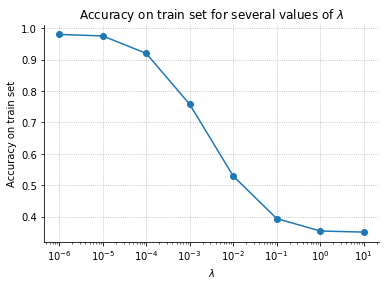

In [53]:
import matplotlib.pyplot as plt
plt.plot(np.array(lambd_list)[::-1], np.array(accuracy_list)[::-1], '-o')
plt.semilogx()
plt.xlabel("$\lambda$")
plt.ylabel("Accuracy on train set")
plt.title("Accuracy on train set for several values of $\lambda$")
plt.grid(ls=':')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

In [33]:
krr = KRR(kernel=Linear().kernel)
krr.fit(Xtr, Ytr)
pred = krr.predict(Xte)
print(pred)

[3. 0. 0. ... 0. 0. 0.]


In [34]:
ar_unique, i = np.unique(pred, return_counts=True)
i

array([792, 375, 300, 220, 163,  77,  39,  18,   9,   7], dtype=int64)

In [57]:
from tqdm import tqdm
accuracy_list = []
sigma_list = [10, 1, 1e-1, 1e-2, 1e-3]
for sigma in sigma_list:
    krr = MultiKRR(kernel=GaussianKernel(sigma=sigma).kernel)
    krr.fit(Xtr, Ytr)
    pred = krr.predict(Xtr)
    accuracy_list.append(accuracy(Ytr, pred))

Fitting:   0%|          | 0/10 [00:00<?, ?it/s]